# Toggle-Frame Example Problem: Single Drive

This notebook illustrates the effectiveness of the toggling-frame robustness objective for both multiplicative and additive errors for a single pauli X drive and Hadamard as the unitary goal. It's strucuted as follows:
* Imports
* Problem Setup 
* Problem Solve
* Plot fidelity swept over additive & multiplicative error 
* Save trjaectories to file

## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics
using CairoMakie
using NamedTrajectories
using TrajectoryIndexingUtils
using Random

  Activating project at `~/Documents/GitHub/robust_control_sam/src`
Precompiling project...
   4332.0 ms  ✓ QuantumCollocation
  1 dependency successfully precompiled in 7 seconds. 575 already precompiled.
   Resolving package versions...
  No Changes to `~/Documents/GitHub/robust_control_sam/src/Project.toml`
  No Changes to `~/Documents/GitHub/robust_control_sam/src/Manifest.toml`


## Problem Setup

In [2]:
# Problem parameters
T = 40
Δt = 0.2
U_goal = GATES.Z
H_drift = 0.2 * PAULIS.Y
H_drive = PAULIS.X
a_bound = 1.0
dda_bound = 4.0
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drift, [H_drive])

QuantumSystem: levels = 2, n_drives = 1

In [3]:
sys.H.H_drives

1-element Vector{SparseMatrixCSC{ComplexF64, Int64}}:
 sparse([2, 1], [1, 2], ComplexF64[1.0 + 0.0im, 1.0 + 0.0im], 2, 2)

In [4]:
# additive error Hamiltonian
Hₑ_add = a -> PAULIS.X

# multiplicative error Hamiltonian
X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive

# no robustness
default = UnitarySmoothPulseProblem(sys, U_goal, T, Δt)
solve!(default, max_iter=200, print_level=5)

# additive robustness
add_prob = UnitarySmoothPulseProblem(
            sys, U_goal, T, Δt;
            piccolo_options=piccolo_opts,
            activate_rob_loss=true,
            H_err=Hₑ_add,
            Q_t=1.0
        )
solve!(add_prob, max_iter=200, print_level=5)

# multiplicative robustness
mult_prob = UnitarySmoothPulseProblem(
    sys, U_goal, T, Δt;
    piccolo_options=piccolo_opts,
    activate_rob_loss=true,
    H_err=Hₑ_mult,
    Q_t=1.0
)
solve!(mult_prob, max_iter=200, print_level=5)

    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, runnin

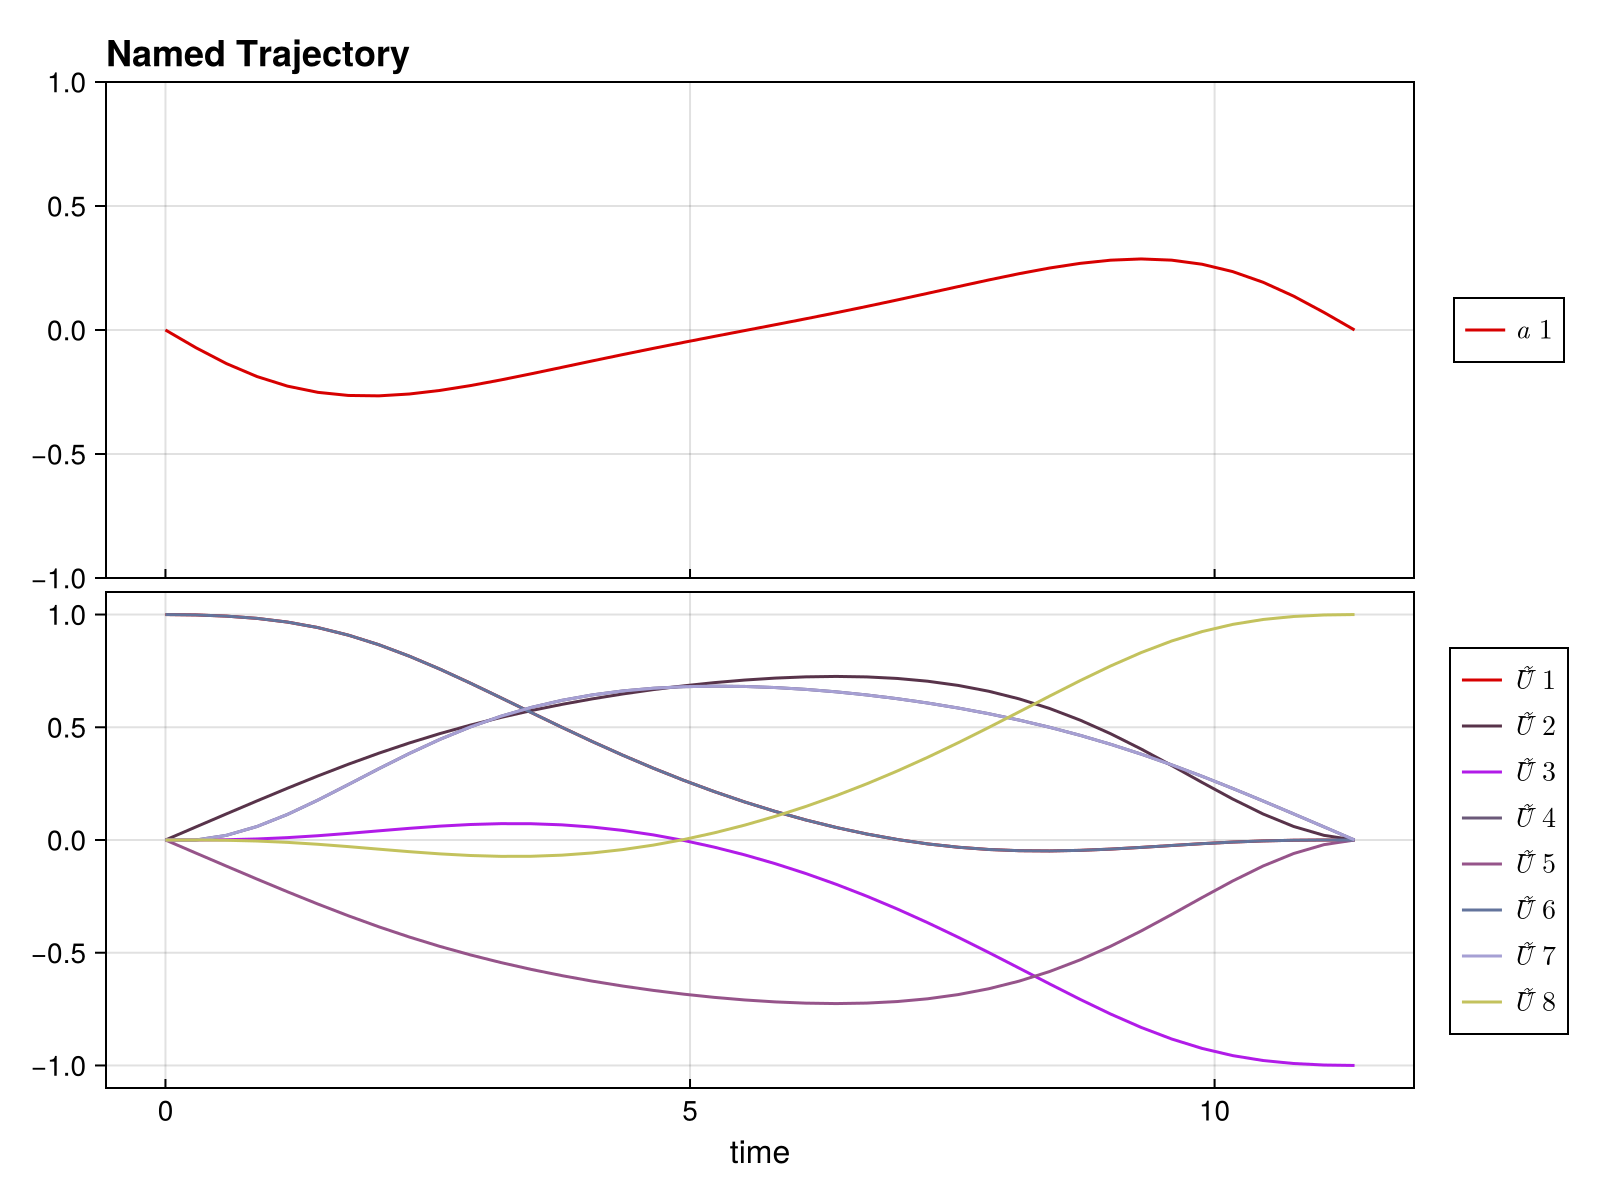

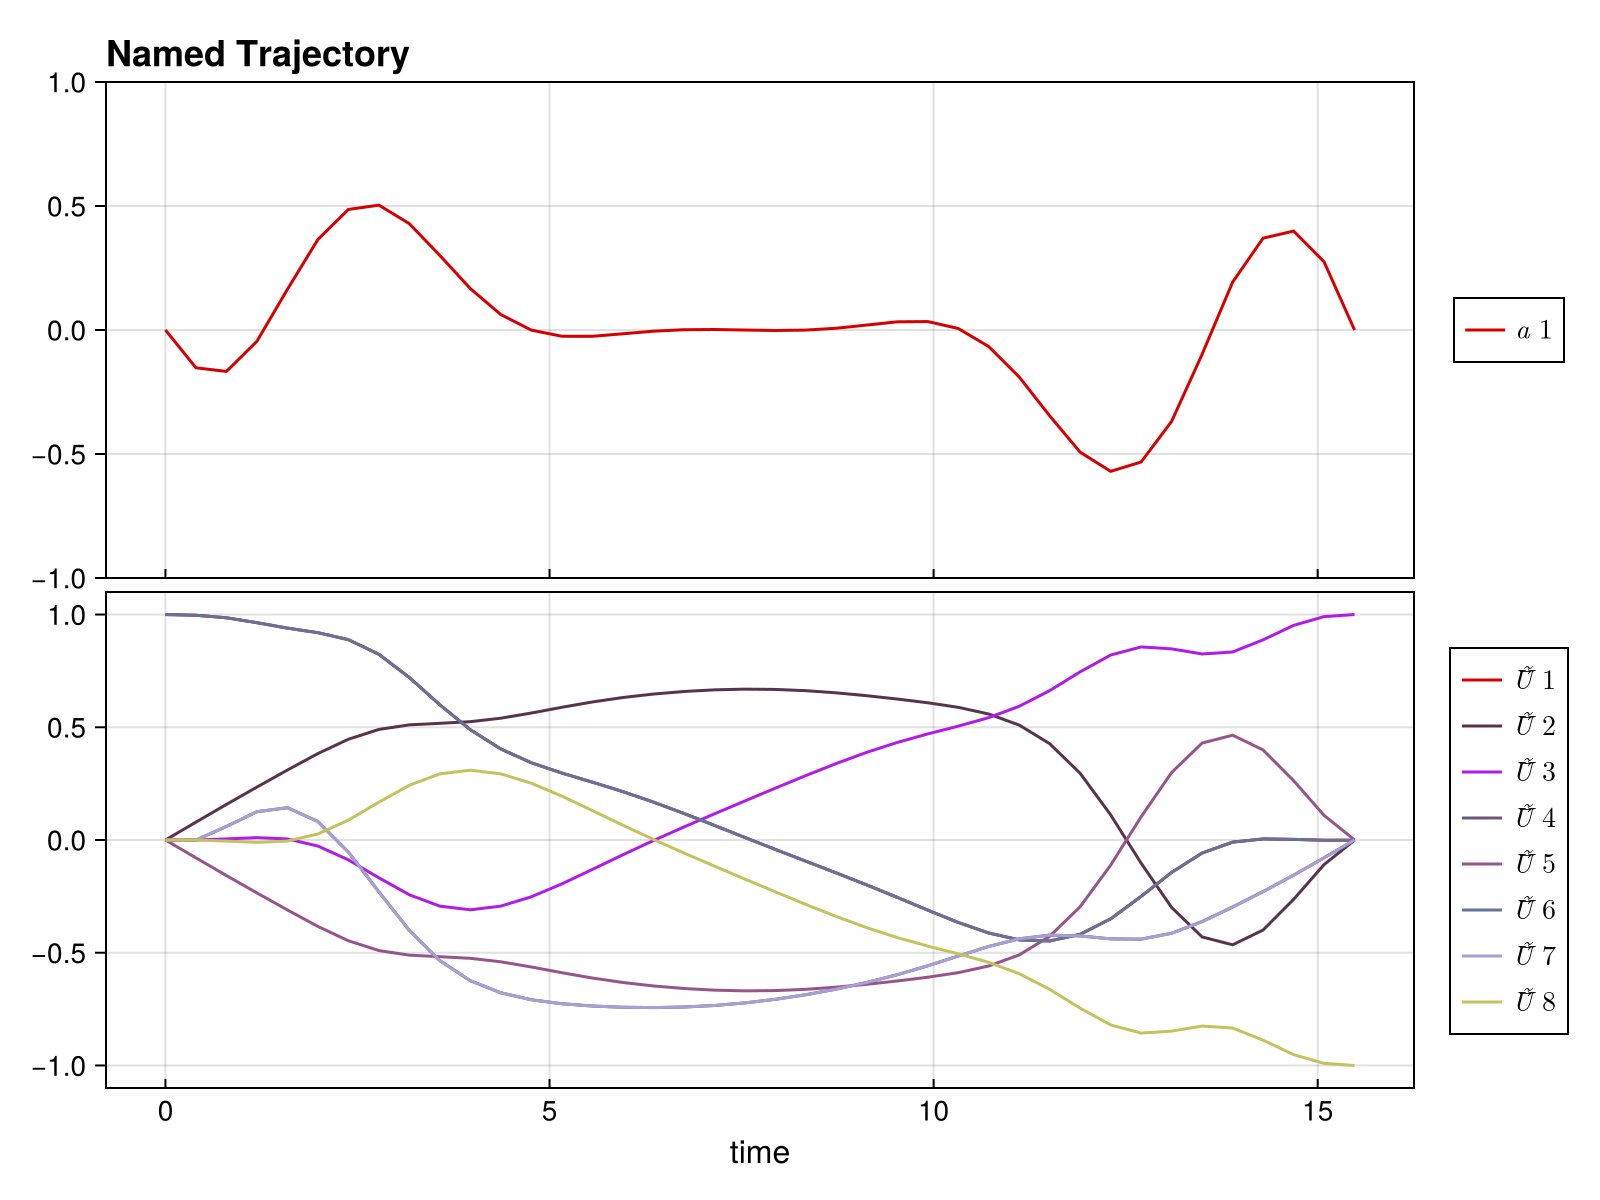

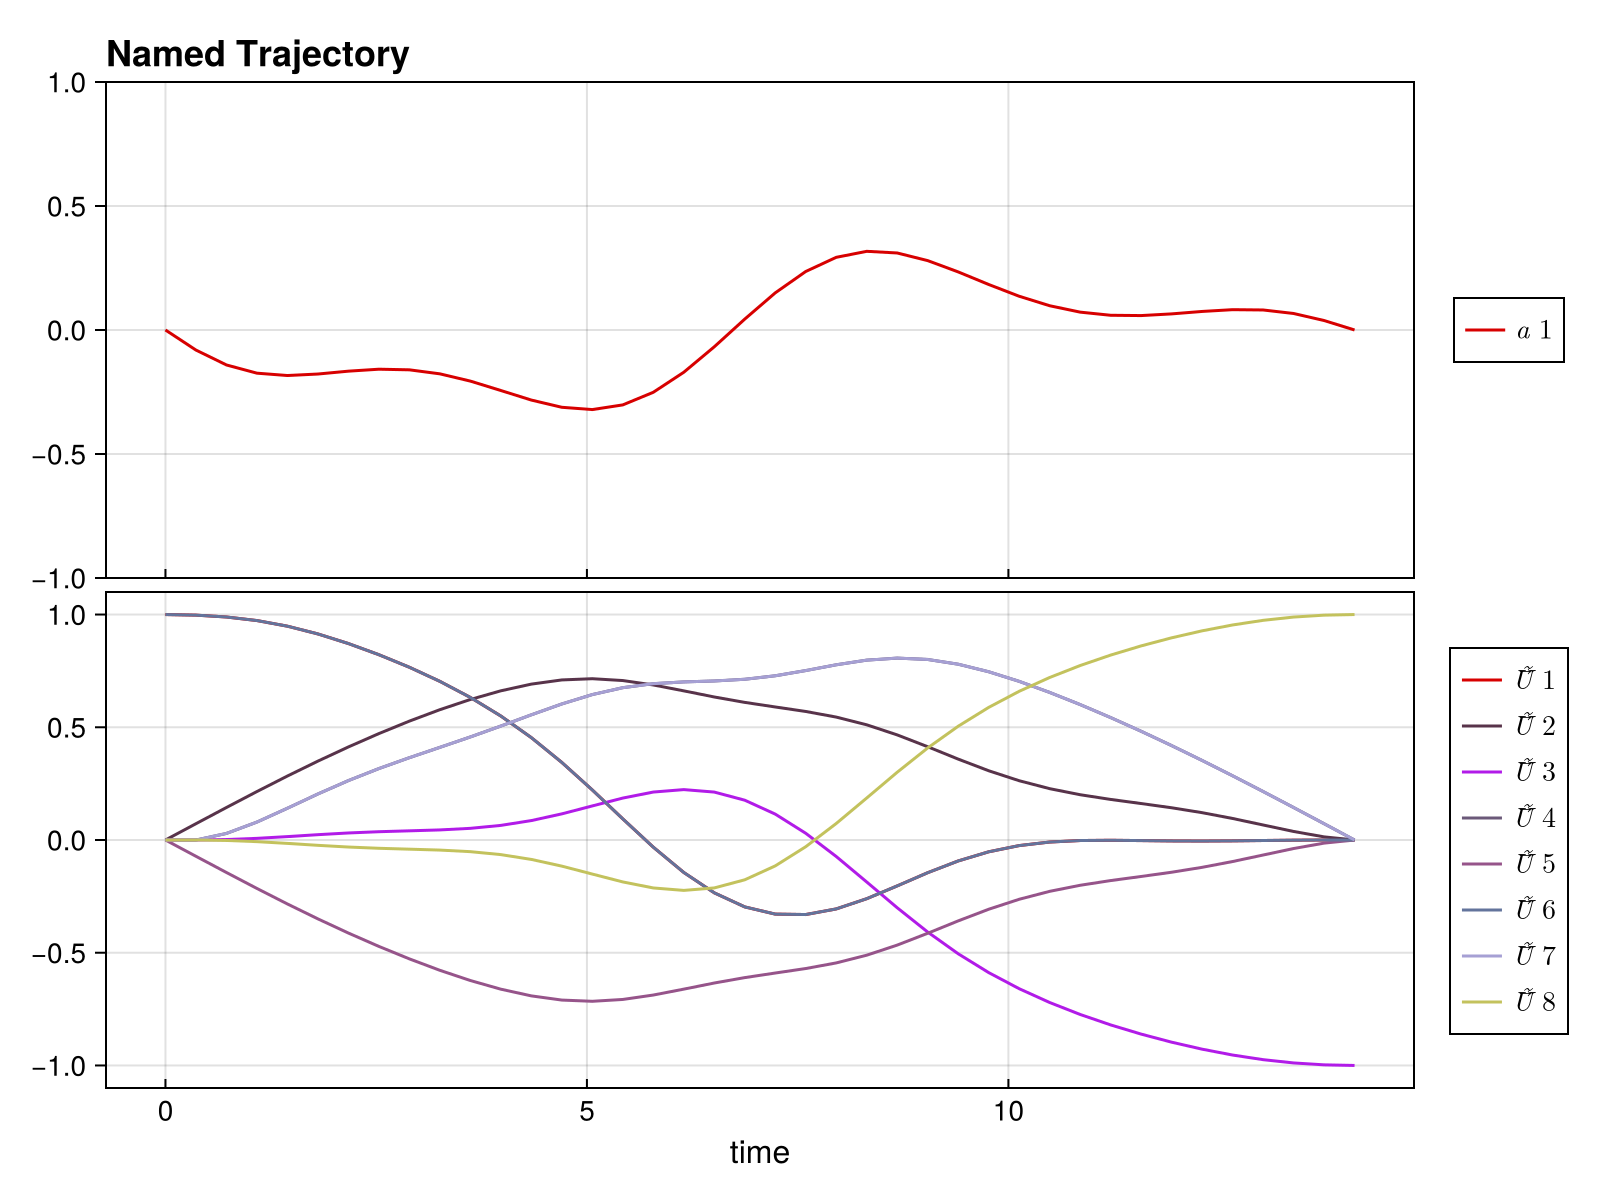

CairoMakie.Screen{IMAGE}


In [5]:
p1 = CairoMakie.plot(default.trajectory, [:a, :Ũ⃗])
p2 = CairoMakie.plot(add_prob.trajectory, [:a, :Ũ⃗])
p3 = CairoMakie.plot(mult_prob.trajectory, [:a, :Ũ⃗])

display(p1)
display(p2)
display(p3)

#### Plotting

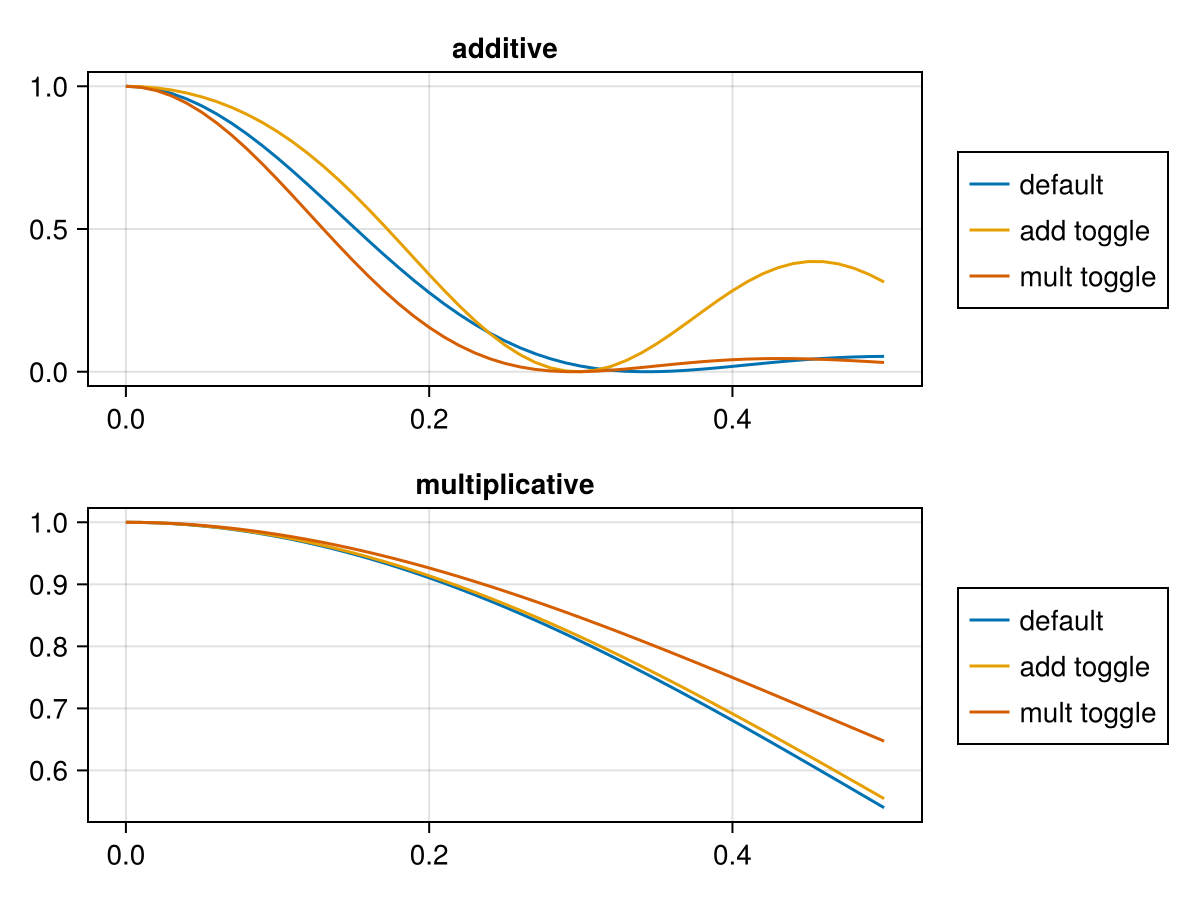

In [6]:
H_drive_add = H_drive

f = Figure()
ax1 = Axis(f[1, 1], title="additive")
ax2 = Axis(f[2, 1], title="multiplicative")

colors = Makie.wong_colors()

εs = 0:0.01:.5

# default case (smooth, non-variational, w/o toggling obj)

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X])) for ε in εs]
lines!(ax1, εs, ys, label="default", color=colors[1], linestyle=:solid)

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
lines!(ax2, εs, ys, label="default", color=colors[1], linestyle=:solid)

# toggling obj

# (add)
ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X])) for ε in εs]
lines!(ax1, εs, ys, label="add toggle", color=colors[2], linestyle=:solid)

ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
lines!(ax2, εs, ys, label="add toggle", color=colors[2], linestyle=:solid)

# (mult)
ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X])) for ε in εs]
lines!(ax1, εs, ys, label="mult toggle", color=colors[6], linestyle=:solid)

ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
lines!(ax2, εs, ys, label="mult toggle", color=colors[6], linestyle=:solid)

# # (both)
# ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
# lines!(ax1, εs, ys, label="both toggle", color=colors[4], linestyle=:solid)

# ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
# lines!(ax2, εs, ys, label="both toggle", color=colors[4], linestyle=:solid)

Legend(f[1,2], ax1, position=:lb)
Legend(f[2,2], ax2, position=:lb)

f


In [7]:
# ---------- Summary statistics ----------

# Helper to avoid division-by-zero in % improvement
safe_improvement(base, rob) = base == 0 ? 0.0 : (base - rob) / base * 100

# Build infidelity arrays over the same ε grid you defined earlier
# (Additive model: H = ε X + H_drift, drive = X)
additive_base_infids  = [1 - unitary_rollout_fidelity(default.trajectory,
                            QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X])) for ε in εs]
additive_robust_infids = [1 - unitary_rollout_fidelity(add_prob.trajectory,
                            QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X])) for ε in εs]
additive_improvements = [safe_improvement(additive_base_infids[i], additive_robust_infids[i])
                         for i in eachindex(additive_base_infids)]

# (Multiplicative model: H = H_drift, drive = (1+ε) X)
mult_base_infids  = [1 - unitary_rollout_fidelity(default.trajectory,
                        QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
mult_robust_infids = [1 - unitary_rollout_fidelity(mult_prob.trajectory,
                        QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
mult_improvements = [safe_improvement(mult_base_infids[i], mult_robust_infids[i])
                     for i in eachindex(mult_base_infids)]

error_magnitudes = collect(εs)

println("\nAdditive Error Results:")
println("Average base infidelity: $(round(mean(additive_base_infids), digits=4))")
println("Average robust infidelity: $(round(mean(additive_robust_infids), digits=4))")
println("Average improvement: $(round(mean(additive_improvements), digits=2))%")
println("Max improvement: $(round(maximum(additive_improvements), digits=2))%")

println("\nMultiplicative Error Results:")
println("Average base infidelity: $(round(mean(mult_base_infids), digits=4))")
println("Average robust infidelity: $(round(mean(mult_robust_infids), digits=4))")
println("Average improvement: $(round(mean(mult_improvements), digits=2))%")
println("Max improvement: $(round(maximum(mult_improvements), digits=2))%")

# Which error type benefits more?
avg_add_improvement = mean(additive_improvements)
avg_mult_improvement = mean(mult_improvements)

println("\nComparison:")
if avg_add_improvement > avg_mult_improvement
    println(" Additive errors benefit more from robust optimization")
    println("  Difference: $(round(avg_add_improvement - avg_mult_improvement, digits=2))% better")
elseif avg_mult_improvement > avg_add_improvement
    println(" Multiplicative errors benefit more from robust optimization")
    println("  Difference: $(round(avg_mult_improvement - avg_add_improvement, digits=2))% better")
else
    println(" Tie: both see the same average improvement")
end

println("\n Results Table:")
println("Error ε  | Add Base | Add Rob  | Add Imp% | Mult Base| Mult Rob | Mult Imp%")
println("-" ^ 75)
for i in eachindex(error_magnitudes)
    println("$(lpad(round(error_magnitudes[i], digits=4), 7)) | " *
            "$(lpad(round(additive_base_infids[i],  digits=4), 8)) | " *
            "$(lpad(round(additive_robust_infids[i], digits=4), 8)) | " *
            "$(lpad(round(additive_improvements[i], digits=1), 8)) | " *
            "$(lpad(round(mult_base_infids[i],     digits=4), 9)) | " *
            "$(lpad(round(mult_robust_infids[i],    digits=4), 8)) | " *
            "$(lpad(round(mult_improvements[i],    digits=1), 9))")
end



Additive Error Results:
Average base infidelity: 0.6777
Average robust infidelity: 0.5658
Average improvement: -17485.02%
Max improvement: 48.92%

Multiplicative Error Results:
Average base infidelity: 0.1697
Average robust infidelity: 0.1339
Average improvement: -75.1%
Max improvement: 23.32%

Comparison:
 Multiplicative errors benefit more from robust optimization
  Difference: 17409.92% better

 Results Table:
Error ε  | Add Base | Add Rob  | Add Imp% | Mult Base| Mult Rob | Mult Imp%
---------------------------------------------------------------------------
    0.0 |      0.0 |      0.0 | -892841.7 |       0.0 |      0.0 |   -4768.8
   0.01 |   0.0028 |   0.0014 |     48.9 |    0.0002 |   0.0002 |      14.4
   0.02 |   0.0112 |   0.0058 |     48.5 |    0.0009 |   0.0008 |      14.2
   0.03 |   0.0251 |   0.0131 |     47.9 |    0.0021 |   0.0018 |      14.2
   0.04 |   0.0443 |   0.0235 |     47.0 |    0.0037 |   0.0032 |      14.4
   0.05 |   0.0685 |   0.0371 |     45.8 |    0.0

Save Trajectory

In [8]:
using JLD2
using Dates

# Collect just the three trajectories from your problems
default_traj   = default.trajectory
add_traj       = add_prob.trajectory
mult_traj      = mult_prob.trajectory

# Optional: store both fidelity and infidelity traces used above
fid_traces = Dict(
    "εs" => error_magnitudes,
    # Additive
    "additive_base_infids"   => additive_base_infids,
    "additive_robust_infids" => additive_robust_infids,
    "additive_improvements"  => additive_improvements,
    # Multiplicative
    "mult_base_infids"       => mult_base_infids,
    "mult_robust_infids"     => mult_robust_infids,
    "mult_improvements"      => mult_improvements,
)

# Minimal metadata to reconstruct the setup
meta = Dict(
    "T"         => T,
    "Δt"        => Δt,
    "U_goal"    => U_goal,
    "a_bound"   => a_bound,
    "dda_bound" => dda_bound,
    "H_drift"   => H_drift,
    "H_drive"   => H_drive,
    "robust_opts" => Dict("Q_t" => 1.0,
                          "Hₑ_add" => "ε * X added to drift",
                          "Hₑ_mult" => "(1+ε) scaling of X drive")
)

# Save into artifacts/ with timestamped filename
mkpath("artifacts")
timestamp = Dates.format(Dates.now(), "yyyymmdd_HHMMSS")
outfile = joinpath("artifacts", "single_run_trajectories_$(timestamp).jld2")

@info "Saving trajectories and traces to $outfile"
@save outfile default_traj add_traj mult_traj fid_traces meta
@info "Done. Saved keys: default_traj, add_traj, mult_traj, fid_traces, meta"


┌ Info: Saving trajectories and traces to artifacts/single_run_trajectories_20250904_165336.jld2
└ @ Main /Users/andrewkamen/Documents/GitHub/robust_control_sam/src/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X15sZmlsZQ==.jl:41
┌ Info: Done. Saved keys: default_traj, add_traj, mult_traj, fid_traces, meta
└ @ Main /Users/andrewkamen/Documents/GitHub/robust_control_sam/src/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X15sZmlsZQ==.jl:43


In [10]:
U_goal

2×2 Matrix{ComplexF64}:
 1.0+0.0im   0.0+0.0im
 0.0+0.0im  -1.0+0.0im

In [9]:
# using JLD2
# @load "artifacts/trajectories_YYYYMMDD_HHMMSS.jld2" default_trajs add_traj mult_traj fid_traces meta
